In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Mac, Windows 사용자 맞게 설정)
import platform
if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')

plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지


# --- 1. 데이터 불러오기 및 전처리 ---
# 다른 파일을 사용하시려면 아래 'Location1.csv' 부분을 파일명으로 바꿔주세요.
file_path = 'Location1.csv' 
df = pd.read_csv(file_path)

df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)
df.rename(columns={'Power': 'target'}, inplace=True)



print(f"--- '{file_path}' 데이터 불러오기 및 특성 공학 완료 ---")
print("데이터 정보:")
print(df.info(verbose=False))
print("\n데이터 샘플:")
df.head()

--- 'Location1.csv' 데이터 불러오기 및 특성 공학 완료 ---
데이터 정보:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2017-01-02 00:00:00 to 2021-12-31 23:00:00
Columns: 9 entries, temperature_2m to target
dtypes: float64(6), int64(3)
memory usage: 3.3 MB
None

데이터 샘플:


,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,target
Time,,,,,,,,,
2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635
2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424
2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214
2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003
2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793


In [7]:
from sklearn.preprocessing import StandardScaler

# --- 3. 데이터 분할 ---
n = len(df)
train_end = int(n * 0.7)
val_end = int(n * (0.7 + 0.15))

# .copy()를 사용하여 SettingWithCopyWarning 방지
train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()

print("--- 데이터 분할 결과 ---")
print(f"Train Set: {train_df.shape[0]} samples")
print(f"Validation Set: {val_df.shape[0]} samples")
print(f"Test Set: {test_df.shape[0]} samples")


# --- 4. 데이터 스케일링 ---
features = [col for col in df.columns if col != 'target']
scaler = StandardScaler()

# Train 데이터에 fit 및 transform 수행
train_df[features] = scaler.fit_transform(train_df[features])

# Val, Test 데이터에는 transform만 수행
val_df[features] = scaler.transform(val_df[features])
test_df[features] = scaler.transform(test_df[features])

print("\n--- 데이터 스케일링 완료 ---")
print("스케일링 후 Train 데이터 샘플:")
train_df.head()

--- 데이터 분할 결과 ---
Train Set: 30659 samples
Validation Set: 6571 samples
Test Set: 6570 samples

--- 데이터 스케일링 완료 ---
스케일링 후 Train 데이터 샘플:


,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,target
Time,,,,,,,,,
2017-01-02 00:00:00,-0.919244,0.757421,-0.667715,-1.311702,-1.880974,-0.566672,-0.394205,-1.788871,0.1635
2017-01-02 01:00:00,-0.924367,0.816643,-0.657193,-0.939601,-0.869135,-0.515424,-0.434630,-0.957529,0.1424
2017-01-02 02:00:00,-1.006343,1.112749,-0.667715,-1.395725,-1.317606,-0.546173,-0.515480,-1.290066,0.1214
2017-01-02 03:00:00,-0.975602,0.935085,-0.678237,-1.395725,-1.350963,-1.468645,-0.970265,-1.733448,0.1003
2017-01-02 04:00:00,-0.980726,0.935085,-0.688759,-0.693534,-0.706055,-1.468645,-1.182497,-1.068375,0.0793


In [8]:
import numpy as np

# 시계열 데이터를 입력(X)과 출력(y) 시퀀스로 변환하는 함수
def create_sequences(input_data, sequence_length, prediction_horizon):
    X, y = [], []
    features = [col for col in input_data.columns if col != 'target']
    data_len = len(input_data)
    
    for i in range(data_len - sequence_length - prediction_horizon + 1):
        # 입력 시퀀스: i 부터 i+sequence_length 까지의 데이터
        sequence = input_data.iloc[i:(i + sequence_length)]
        
        # 정답(라벨): i+sequence_length 에서 prediction_horizon 만큼 뒤의 'target' 값
        label_position = i + sequence_length + prediction_horizon - 1
        label = input_data.iloc[label_position]['target']
        
        X.append(sequence[features].values)
        y.append(label)
        
    return np.array(X), np.array(y)

# 시퀀스 길이와 예측 시점 정의
SEQUENCE_LENGTH = 24 * 7 # 7일 (168시간)
PREDICTION_HORIZON = 1   # 1시간 뒤

# 각 데이터셋을 시퀀스 형태로 변환
X_train, y_train = create_sequences(train_df, SEQUENCE_LENGTH, PREDICTION_HORIZON)
X_val, y_val = create_sequences(val_df, SEQUENCE_LENGTH, PREDICTION_HORIZON)
X_test, y_test = create_sequences(test_df, SEQUENCE_LENGTH, PREDICTION_HORIZON)

# 변환된 데이터의 형태(shape) 확인
print("--- 시퀀스 데이터 생성 완료 ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

--- 시퀀스 데이터 생성 완료 ---
X_train shape: (30491, 168, 8)
y_train shape: (30491,)
X_val shape: (6403, 168, 8)
y_val shape: (6403,)
X_test shape: (6402, 168, 8)
y_test shape: (6402,)


In [9]:
import torch
import torch.nn as nn
import math
from torch.utils.data import TensorDataset, DataLoader

# --- 5. PyTorch 데이터로더 생성 ---
BATCH_SIZE = 32

# NumPy 배열을 PyTorch Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# TensorDataset 및 DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("--- PyTorch DataLoader 준비 완료 ---")


# --- 6. 트랜스포머 모델 정의 및 초기화 ---

# 위치 정보를 위한 포지셔널 인코딩 클래스
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# 트랜스포머 모델 클래스
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        
        self.encoder = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])
        return output

# 하이퍼파라미터 및 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INPUT_SIZE = X_train.shape[2] # 10
D_MODEL = 64
NHEAD = 4
NUM_ENCODER_LAYERS = 3
DIM_FEEDFORWARD = 256
LEARNING_RATE = 0.001

model_tf = TransformerModel(INPUT_SIZE, D_MODEL, NHEAD, NUM_ENCODER_LAYERS, DIM_FEEDFORWARD).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_tf.parameters(), lr=LEARNING_RATE)

print(f"\n--- 트랜스포머 모델 준비 완료 (Device: {device}) ---")
print("모델 구조:")
print(model_tf)

--- PyTorch DataLoader 준비 완료 ---

--- 트랜스포머 모델 준비 완료 (Device: cuda) ---
모델 구조:
TransformerModel(
  (encoder): Linear(in_features=8, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=64, out_features=1, bias=True)
)


--- 트랜스포머 모델 학습 시작 ---


Epoch 1/50 [Train]: 100%|██████████| 953/953 [00:08<00:00, 110.54it/s, loss=0.0221]


Epoch 1/50 | Train Loss: 0.033130 | Val Loss: 0.032735


Epoch 2/50 [Train]: 100%|██████████| 953/953 [00:08<00:00, 113.36it/s, loss=0.0303]


Epoch 2/50 | Train Loss: 0.027350 | Val Loss: 0.030329


Epoch 3/50 [Train]: 100%|██████████| 953/953 [00:08<00:00, 105.89it/s, loss=0.0153] 


Epoch 3/50 | Train Loss: 0.025874 | Val Loss: 0.028917


Epoch 4/50 [Train]: 100%|██████████| 953/953 [00:09<00:00, 103.00it/s, loss=0.0156]


Epoch 4/50 | Train Loss: 0.024040 | Val Loss: 0.029394


Epoch 5/50 [Train]: 100%|██████████| 953/953 [00:10<00:00, 95.18it/s, loss=0.0205]  


Epoch 5/50 | Train Loss: 0.022978 | Val Loss: 0.032503


Epoch 6/50 [Train]: 100%|██████████| 953/953 [00:14<00:00, 67.45it/s, loss=0.0267] 


Epoch 6/50 | Train Loss: 0.021848 | Val Loss: 0.033311


Epoch 7/50 [Train]: 100%|██████████| 953/953 [00:26<00:00, 36.08it/s, loss=0.0221] 


Epoch 7/50 | Train Loss: 0.021400 | Val Loss: 0.030410


Epoch 8/50 [Train]: 100%|██████████| 953/953 [00:24<00:00, 39.02it/s, loss=0.0192] 


Epoch 8/50 | Train Loss: 0.019968 | Val Loss: 0.029940
Early stopping triggered.

--- 학습 종료 (총 학습 시간: 114.67초) ---
최적 모델 'best_model_tf.pth' 로드 완료.


[Final Test]: 100%|██████████| 201/201 [00:00<00:00, 317.46it/s]



--- 트랜스포머 모델 최종 성능 평가 결과 ---
MAE: 0.1234
RMSE: 0.1611
R-squared (결정 계수): 0.6860


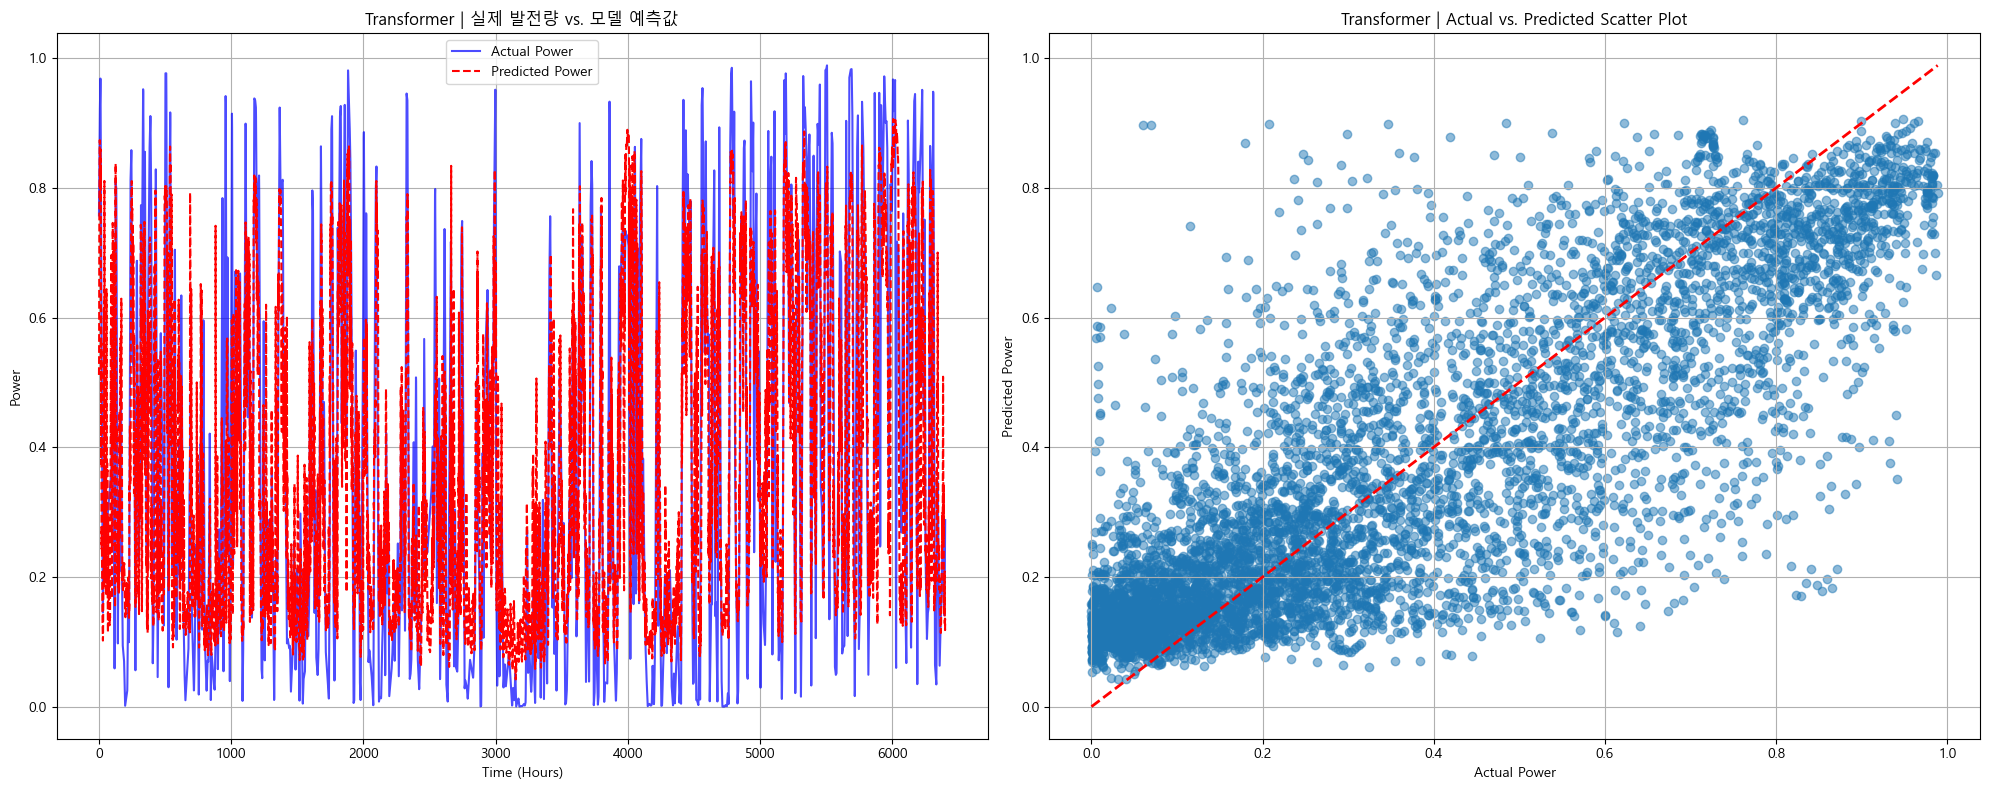

In [10]:
import time
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 7. 트랜스포머 모델 학습 및 평가 ---

NUM_EPOCHS = 50
PATIENCE = 5
best_val_loss = float('inf')
early_stopping_counter = 0
best_model_path_tf = 'best_model_tf.pth'

print("--- 트랜스포머 모델 학습 시작 ---")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model_tf.train()
    train_loss = 0.0
    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")

    for inputs, labels in train_iterator:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_tf(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item()})
    
    avg_train_loss = train_loss / len(train_loader)

    model_tf.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_tf(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model_tf.state_dict(), best_model_path_tf)
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    
    if early_stopping_counter >= PATIENCE:
        print("Early stopping triggered.")
        break

end_time = time.time()
print(f"\n--- 학습 종료 (총 학습 시간: {end_time - start_time:.2f}초) ---")

# --- 최종 평가 ---
model_tf.load_state_dict(torch.load(best_model_path_tf))
print(f"최적 모델 '{best_model_path_tf}' 로드 완료.")

model_tf.eval()
all_predictions = []
all_actuals = []

with torch.no_grad():
    test_iterator = tqdm(test_loader, desc="[Final Test]")
    for inputs, labels in test_iterator:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_tf(inputs)
        all_predictions.append(outputs.squeeze().cpu().numpy())
        all_actuals.append(labels.cpu().numpy())

predictions = np.concatenate(all_predictions)
actuals = np.concatenate(all_actuals)

mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)

print("\n--- 트랜스포머 모델 최종 성능 평가 결과 ---")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared (결정 계수): {r2:.4f}")

# --- 결과 시각화 ---
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(actuals, label='Actual Power', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicted Power', color='red', linestyle='--')
plt.title('Transformer | 실제 발전량 vs. 모델 예측값')
plt.xlabel('Time (Hours)')
plt.ylabel('Power')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red', linestyle='--', lw=2)
plt.title('Transformer | Actual vs. Predicted Scatter Plot')
plt.xlabel('Actual Power')
plt.ylabel('Predicted Power')
plt.grid(True)

plt.tight_layout()
plt.show()